# Milestone Project 1: FoodVision

In [ ]:
#Check GPU
!nvidia-smi -L


GPU 0: Tesla T4 (UUID: GPU-da080272-33d0-414b-27a4-91d0e32e1108)


In [ ]:
# Getting helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-07-01 09:26:38--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-01 09:26:38 (76.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import *

## Use TensorFlow Datasets to Download Data



In [ ]:
import tensorflow_datasets as tfds

(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
class_names = ds_info.features["label"].names

In [ ]:
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
train_one_sample = train_data.take(1)

In [ ]:
for image, label in train_one_sample:
  print(f"""
  Image Shape: {image.shape}
  Image datatype: {image.dtype}
  Target classe: {label}
  Class name: {class_names[label.numpy()]}
  """)


  Image Shape: (512, 384, 3)
  Image datatype: <dtype: 'uint8'>
  Target classe: 19
  Class name: chicken_quesadilla
  


(-0.5, 383.5, 511.5, -0.5)

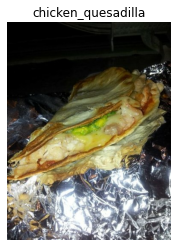

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label])
plt.axis(False)

In [ ]:
import tensorflow as tf
def preprocess_img(image, label, img_shape=224):
  """
  converts image datatype from `uint8` -> tf.float32 and reshapes image
  to [img_shape, img_shape, colour_channels]
  """

  image = tf.image.resize(image, [img_shape, img_shape])
  return (tf.cast(image, tf.float32), label)


In [ ]:
processed = preprocess_img(image, label)[0]

In [ ]:
image.shape, image.dtype, image[:2]

(TensorShape([512, 384, 3]),
 tf.uint8,
 <tf.Tensor: shape=(2, 384, 3), dtype=uint8, numpy=
 array([[[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 7,  7,  5],
         [11, 11,  9],
         [14, 14, 12]],
 
        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 5,  5,  3],
         [ 8,  8,  6],
         [11, 11,  9]]], dtype=uint8)>)

In [ ]:
processed.shape, processed.dtype, processed[:2]

(TensorShape([224, 224, 3]),
 tf.float32,
 <tf.Tensor: shape=(2, 224, 3), dtype=float32, numpy=
 array([[[ 0.       ,  0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       ],
         ...,
         [ 7.7907934,  7.7907934,  5.7907934],
         [ 5.714286 ,  5.714286 ,  3.7142856],
         [10.999987 , 10.999987 ,  8.999987 ]],
 
        [[ 0.       ,  0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       ],
         ...,
         [ 6.770399 ,  6.770399 ,  4.770399 ],
         [ 6.790833 ,  6.790833 ,  4.790833 ],
         [10.1887665, 10.1887665,  8.1887665]]], dtype=float32)>)

## Batch & prepare datasets

In [ ]:
# Map preprocessing function to training and parallelize
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train_data and turn it into batches and prefetch it
train_data = train_data.shuffle(buffer_size=2000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)


#Test Data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

## Create modelling callbacks

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("models/checkpoints/big_check.h5",
                                                save_best_only=True,
                                                monitor="val_accuracy",
                                                verbose=0)

tensorboard_callback = create_tensorboard_callback("tensorboard_logs", "Big Boy")

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                   patience=3)

Saving TensorBoard log files to: tensorboard_logs/Big Boy/20220701-110456


## Setup Mixed Precision Training

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [ ]:
## Build Feature Extraction model

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2)
], name="data_augmentation")

input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB4(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)


model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb4 (Functional)  (None, None, None, 1792)  17673823 
                                                                 
 global_average_pooling2d_1   (None, 1792)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 101)               181093    
                                                                 
 softmax_float32 (Activation  (None, 101)              0   

In [ ]:
for layer in model.layers[2].layers:
  print(f"{layer.name} \t {layer.dtype}\t{layer.dtype_policy}")

input_3 	 float32	<Policy "float32">
rescaling_2 	 float32	<Policy "mixed_float16">
normalization_2 	 float32	<Policy "mixed_float16">
stem_conv_pad 	 float32	<Policy "mixed_float16">
stem_conv 	 float32	<Policy "mixed_float16">
stem_bn 	 float32	<Policy "mixed_float16">
stem_activation 	 float32	<Policy "mixed_float16">
block1a_dwconv 	 float32	<Policy "mixed_float16">
block1a_bn 	 float32	<Policy "mixed_float16">
block1a_activation 	 float32	<Policy "mixed_float16">
block1a_se_squeeze 	 float32	<Policy "mixed_float16">
block1a_se_reshape 	 float32	<Policy "mixed_float16">
block1a_se_reduce 	 float32	<Policy "mixed_float16">
block1a_se_expand 	 float32	<Policy "mixed_float16">
block1a_se_excite 	 float32	<Policy "mixed_float16">
block1a_project_conv 	 float32	<Policy "mixed_float16">
block1a_project_bn 	 float32	<Policy "mixed_float16">
block1b_dwconv 	 float32	<Policy "mixed_float16">
block1b_bn 	 float32	<Policy "mixed_float16">
block1b_activation 	 float32	<Policy "mixed_float16">


In [ ]:
history = model.fit(train_data,
                    epochs=5,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps = int(0.1 * len(test_data)),
                    callbacks = [tensorboard_callback, checkpoint, early_stopping])

Epoch 1/5
2368/2368 [==============================] - 408s 161ms/step - loss: 2.2891 - accuracy: 0.4452 - val_loss: 1.5143 - val_accuracy: 0.6036
Epoch 2/5
2368/2368 [==============================] - 323s 135ms/step - loss: 1.8522 - accuracy: 0.5327 - val_loss: 1.4002 - val_accuracy: 0.6278
Epoch 3/5
2368/2368 [==============================] - 298s 125ms/step - loss: 1.7335 - accuracy: 0.5579 - val_loss: 1.3483 - val_accuracy: 0.6396
Epoch 4/5
2368/2368 [==============================] - 293s 122ms/step - loss: 1.6645 - accuracy: 0.5742 - val_loss: 1.3378 - val_accuracy: 0.6432
Epoch 5/5
2368/2368 [==============================] - 296s 124ms/step - loss: 1.5992 - accuracy: 0.5880 - val_loss: 1.3266 - val_accuracy: 0.6519


In [ ]:
model.evaluate(test_data)

790/790 [==============================] - 88s 112ms/step - loss: 1.3185 - accuracy: 0.6456


[1.3184764385223389, 0.6455841660499573]

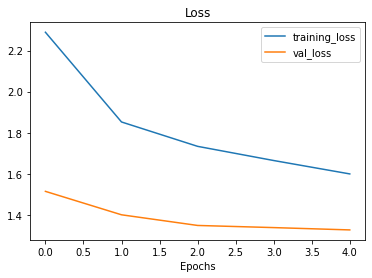

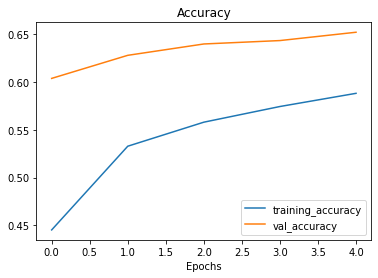

In [ ]:
plot_loss_curves(history)

In [ ]:
for layer in base_model.layers:
  if "block7" in layer.name:
    layer.trainable=True

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=["accuracy"])

print(model.optimizer.learning_rate)
for i, layer in enumerate(model.layers[2].layers):
  print(i, layer.name, layer.trainable)

checkpoint_2 = tf.keras.callbacks.ModelCheckpoint("models/checkpoints/big_check_2.h5",
                                                save_best_only=True,
                                                monitor="val_accuracy",
                                                verbose=0)

tensorboard_callback_2 = create_tensorboard_callback("tensorboard_logs", "Big_Boy_2")

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                   patience=3)

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block1b_dwconv False
18 block1b_bn False
19 block1b_activation False
20 block1b_se_squeeze False
21 block1b_se_reshape False
22 block1b_se_reduce False
23 block1b_se_expand False
24 block1b_se_excite False
25 block1b_project_conv False
26 block1b_project_bn False
27 block1b_drop False
28 block1b_add False
29 block2a_expand_conv False
30 block2a_expand_bn False
31 block2a_expand_activation False
32 block2a_dwconv_pad False
33 block2a_dwconv False
34 block2a_bn False
35 block2a_activation False
36 block2a_se_squeeze False

In [ ]:
fine_tune_epochs = 14

history_2 = model.fit(train_data,
                      epochs=fine_tune_epochs,
                      validation_data=test_data,
                      validation_steps=int(0.1*len(test_data)),
                      callbacks=[checkpoint_2, tensorboard_callback_2, early_stopping],
                      initial_epoch=history.epoch[-1])

Epoch 5/14
2368/2368 [==============================] - 301s 121ms/step - loss: 1.4783 - accuracy: 0.6199 - val_loss: 1.2568 - val_accuracy: 0.6717
Epoch 6/14
2368/2368 [==============================] - 285s 119ms/step - loss: 1.4572 - accuracy: 0.6246 - val_loss: 1.2569 - val_accuracy: 0.6701
Epoch 7/14
2368/2368 [==============================] - 281s 117ms/step - loss: 1.4520 - accuracy: 0.6270 - val_loss: 1.2415 - val_accuracy: 0.6756
Epoch 8/14
2368/2368 [==============================] - 281s 117ms/step - loss: 1.4404 - accuracy: 0.6279 - val_loss: 1.2498 - val_accuracy: 0.6784
Epoch 9/14
2368/2368 [==============================] - 284s 119ms/step - loss: 1.4298 - accuracy: 0.6305 - val_loss: 1.2508 - val_accuracy: 0.6744
Epoch 10/14
2368/2368 [==============================] - 282s 118ms/step - loss: 1.4321 - accuracy: 0.6311 - val_loss: 1.2462 - val_accuracy: 0.6733


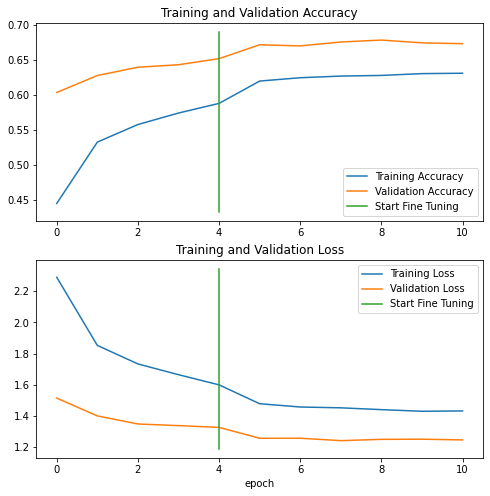

In [ ]:
compare_historys(original_history=history,
                 new_history=history_2,
                 initial_epochs=5)